In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/crowd_wala_dataset.zip'

extract_dir = '/content/drive/MyDrive/crowd_wala_dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: /content/drive/MyDrive/crowd_wala_dataset


In [5]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/crowd_test_data.zip'

extract_dir = '/content/drive/MyDrive/crowd_test_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: /content/drive/MyDrive/crowd_test_data


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import scipy.io as sio
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch.nn.functional as F
from torchvision import models
import warnings
warnings.filterwarnings('ignore')


In [ ]:
TRAIN_IMAGE_DIR = "/content/drive/MyDrive/crowd_wala_dataset/crowd_wala_dataset/train_data/images"
TRAIN_GT_DIR = "/content/drive/MyDrive/crowd_wala_dataset/crowd_wala_dataset/train_data/ground_truth"
TEST_IMAGE_DIR = "/content/drive/MyDrive/crowd_wala_dataset/crowd_wala_dataset/test_data/images"
TEST_GT_DIR = "/content/drive/MyDrive/crowd_wala_dataset/crowd_wala_dataset/test_data/ground_truth"

In [ ]:
class DMCountDataset(Dataset):
    def __init__(self, image_dir, gt_dir, transform=None, is_train=True):
        self.image_dir = image_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.is_train = is_train


        self.image_files = [f for f in os.listdir(image_dir)
                           if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.image_files.sort()

        print(f"Found {len(self.image_files)} images in {image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')


        base_name = os.path.splitext(img_name)[0]
        if 'IMG_' in base_name:
            img_number = base_name.split('IMG_')[-1]
        else:

            import re
            numbers = re.findall(r'\d+', base_name)
            img_number = numbers[-1] if numbers else '1'

        gt_name = f'GT_IMG_{img_number}.mat'
        gt_path = os.path.join(self.gt_dir, gt_name)

        if os.path.exists(gt_path):
            gt_data = sio.loadmat(gt_path)
            if 'image_info' in gt_data:
                points = gt_data['image_info'][0,0]['location'][0,0]
            elif 'annPoints' in gt_data:
                points = gt_data['annPoints']
            else:
                for key in gt_data.keys():
                    if not key.startswith('__') and isinstance(gt_data[key], np.ndarray):
                        if gt_data[key].shape[0] > 0:
                            points = gt_data[key]
                            break
                else:
                    points = np.array([])
        else:
            points = np.array([])

        #  density map banaya hai
        density_map = self.create_density_map(image.size, points)

        if self.transform:
            image = self.transform(image)

        # density map to tensor
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        return image, density_map, len(points) if len(points.shape) > 1 else 0

    def create_density_map(self, img_size, points, sigma=15):
        w, h = img_size
        density_map = np.zeros((h, w), dtype=np.float32)

        if len(points) == 0:
            return density_map
        if len(points.shape) == 1:
            if len(points) >= 2:
                points = points.reshape(1, -1)
            else:
                return density_map

        kernel_size = 6 * sigma + 1
        kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
        center = kernel_size // 2

        for i in range(kernel_size):
            for j in range(kernel_size):
                kernel[i, j] = np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2 * sigma ** 2))

        for point in points:
            if len(point) >= 2:
                x, y = int(point[0]), int(point[1])
                if 0 <= x < w and 0 <= y < h:
                    y_min = max(0, y - center)
                    y_max = min(h, y + center + 1)
                    x_min = max(0, x - center)
                    x_max = min(w, x + center + 1)
                    ky_min = max(0, center - y)
                    ky_max = ky_min + (y_max - y_min)
                    kx_min = max(0, center - x)
                    kx_max = kx_min + (x_max - x_min)
                    density_map[y_min:y_max, x_min:x_max] += kernel[ky_min:ky_max, kx_min:kx_max]

        return density_map


In [ ]:
class DilatedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super(DilatedConvBlock, self).__init__()
        padding = dilation * (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                             padding=padding, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class SelfAttentionModule(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super(SelfAttentionModule, self).__init__()
        self.in_channels = in_channels
        self.reduction = reduction
        self.query_conv = nn.Conv2d(in_channels, in_channels // reduction, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // reduction, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.out_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.softmax = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        query = self.query_conv(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, height * width)
        value = self.value_conv(x).view(batch_size, -1, height * width)
        attention = torch.bmm(query, key)
        attention = self.softmax(attention)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        out = self.out_conv(out)
        out = self.gamma * out + x

        return out

class DMCountPlusPlus(nn.Module):
    def __init__(self, load_weights=True):
        super(DMCountPlusPlus, self).__init__()

        # VGG-16 backbone (up to conv4_3)
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:-3])
        for param in self.frontend[:10].parameters():
            param.requires_grad = False
        self.reg_layer1 = DilatedConvBlock(512, 256, dilation=2)
        self.reg_layer2 = DilatedConvBlock(256, 128, dilation=2)
        self.ms_conv1 = DilatedConvBlock(128, 64, dilation=1)
        self.ms_conv2 = DilatedConvBlock(128, 64, dilation=2)
        self.ms_conv3 = DilatedConvBlock(128, 64, dilation=3)
        self.fusion = nn.Conv2d(192, 64, 1)
        self.fusion_bn = nn.BatchNorm2d(64)
        self.fusion_relu = nn.ReLU(inplace=True)
        self.self_attention = SelfAttentionModule(64, reduction=8)
        self.density_map = nn.Conv2d(64, 1, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.frontend(x)
        x = self.reg_layer1(x)
        x = self.reg_layer2(x)
        ms1 = self.ms_conv1(x)
        ms2 = self.ms_conv2(x)
        ms3 = self.ms_conv3(x)
        ms_features = torch.cat([ms1, ms2, ms3], dim=1)
        fused = self.fusion_relu(self.fusion_bn(self.fusion(ms_features)))
        refined = self.self_attention(fused)
        density = self.density_map(refined)

        return density

In [ ]:
def preprocess_dataset():
    print("Preprocessing training data...")
    processed_train_dir = "/content/processed_train_gt"
    os.makedirs(processed_train_dir, exist_ok=True)


    for filename in os.listdir(TRAIN_GT_DIR):
        if filename.endswith('.mat') and filename.startswith('GT_IMG_'):
            mat_path = os.path.join(TRAIN_GT_DIR, filename)
            try:
                gt_data = sio.loadmat(mat_path)
                if 'image_info' in gt_data:
                    points = gt_data['image_info'][0,0]['location'][0,0]
                elif 'annPoints' in gt_data:
                    points = gt_data['annPoints']
                else:
                    for key in gt_data.keys():
                        if not key.startswith('__') and isinstance(gt_data[key], np.ndarray):
                            if gt_data[key].shape[0] > 0:
                                points = gt_data[key]
                                break
                    else:
                        points = np.array([])
                np_filename = filename.replace('.mat', '.npy')
                np.save(os.path.join(processed_train_dir, np_filename), points)
                print(f"Processed {filename} -> {np_filename}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    print("Preprocessing test data...")
    processed_test_dir = "/content/processed_test_gt"
    os.makedirs(processed_test_dir, exist_ok=True)


    for filename in os.listdir(TEST_GT_DIR):
        if filename.endswith('.mat') and filename.startswith('GT_IMG_'):
            mat_path = os.path.join(TEST_GT_DIR, filename)
            try:
                gt_data = sio.loadmat(mat_path)
                if 'image_info' in gt_data:
                    points = gt_data['image_info'][0,0]['location'][0,0]
                elif 'annPoints' in gt_data:
                    points = gt_data['annPoints']
                else:
                    for key in gt_data.keys():
                        if not key.startswith('__') and isinstance(gt_data[key], np.ndarray):
                            if gt_data[key].shape[0] > 0:
                                points = gt_data[key]
                                break
                    else:
                        points = np.array([])
                np_filename = filename.replace('.mat', '.npy')
                np.save(os.path.join(processed_test_dir, np_filename), points)
                print(f"Processed {filename} -> {np_filename}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

In [ ]:
def train_model():

    train_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    train_dataset = DMCountDataset(TRAIN_IMAGE_DIR, TRAIN_GT_DIR,
                                  transform=train_transform, is_train=True)
    test_dataset = DMCountDataset(TEST_IMAGE_DIR, TEST_GT_DIR,
                                 transform=test_transform, is_train=False)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DMCountPlusPlus().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    num_epochs = 100
    best_mae = float('inf')

    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, density_maps, counts) in enumerate(train_loader):
            images = images.to(device)
            density_maps = density_maps.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if outputs.size() != density_maps.size():
                outputs = F.interpolate(outputs, size=density_maps.shape[-2:],
                                      mode='bilinear', align_corners=False)

            loss = criterion(outputs, density_maps)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}')

        scheduler.step()
        if (epoch + 1) % 5 == 0:
            model.eval()
            mae_sum = 0.0
            mse_sum = 0.0

            with torch.no_grad():
                for images, density_maps, true_counts in test_loader:
                    images = images.to(device)

                    outputs = model(images)
                    predicted_count = outputs.sum().item()
                    true_count = true_counts.item()

                    mae_sum += abs(predicted_count - true_count)
                    mse_sum += (predicted_count - true_count) ** 2

            mae = mae_sum / len(test_loader)
            mse = mse_sum / len(test_loader)
            rmse = np.sqrt(mse)

            print(f'Epoch [{epoch+1}/{num_epochs}] - MAE: {mae:.2f}, RMSE: {rmse:.2f}')
            if mae < best_mae:
                best_mae = mae
                torch.save(model.state_dict(), '/content/drive/MyDrive/best_dmcount_model.pth')
                print(f'New best model saved with MAE: {best_mae:.2f}')

    print("Training completed!")
    return model

def evaluate_model(model_path=None):
    """Evaluate the trained model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DMCountPlusPlus().to(device)

    if model_path:
        model.load_state_dict(torch.load(model_path, map_location=device))

    test_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_dataset = DMCountDataset(TEST_IMAGE_DIR, TEST_GT_DIR,
                                 transform=test_transform, is_train=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model.eval()
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, density_maps, true_counts in test_loader:
            images = images.to(device)

            outputs = model(images)
            predicted_count = outputs.sum().item()
            true_count = true_counts.item()

            predictions.append(predicted_count)
            ground_truths.append(true_count)

    mae = mean_absolute_error(ground_truths, predictions)
    mse = mean_squared_error(ground_truths, predictions)
    rmse = np.sqrt(mse)

    print(f"Evaluation Results:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")

    return predictions, ground_truths

Starting DM-count++ Crowd Counting Pipeline...
Found 400 images in /content/drive/MyDrive/crowd_wala_dataset/crowd_wala_dataset/train_data/images
Found 316 images in /content/drive/MyDrive/crowd_wala_dataset/crowd_wala_dataset/test_data/images


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 137MB/s]


Starting training...
Epoch [1/100], Batch [0/100], Loss: 0.195483
Epoch [1/100], Batch [10/100], Loss: 0.176512
Epoch [1/100], Batch [20/100], Loss: 0.633013
Epoch [1/100], Batch [30/100], Loss: 0.541225
Epoch [1/100], Batch [40/100], Loss: 0.251489
Epoch [1/100], Batch [50/100], Loss: 0.154943
Epoch [1/100], Batch [60/100], Loss: 0.194907
Epoch [1/100], Batch [70/100], Loss: 1.460575
Epoch [1/100], Batch [80/100], Loss: 0.433371
Epoch [1/100], Batch [90/100], Loss: 0.213279
Epoch [2/100], Batch [0/100], Loss: 0.287033
Epoch [2/100], Batch [10/100], Loss: 0.307845
Epoch [2/100], Batch [20/100], Loss: 0.253470
Epoch [2/100], Batch [30/100], Loss: 0.289324
Epoch [2/100], Batch [40/100], Loss: 0.058337
Epoch [2/100], Batch [50/100], Loss: 1.612780
Epoch [2/100], Batch [60/100], Loss: 0.606693
Epoch [2/100], Batch [70/100], Loss: 0.512593
Epoch [2/100], Batch [80/100], Loss: 0.105362
Epoch [2/100], Batch [90/100], Loss: 0.425599
Epoch [3/100], Batch [0/100], Loss: 0.583559
Epoch [3/100], B

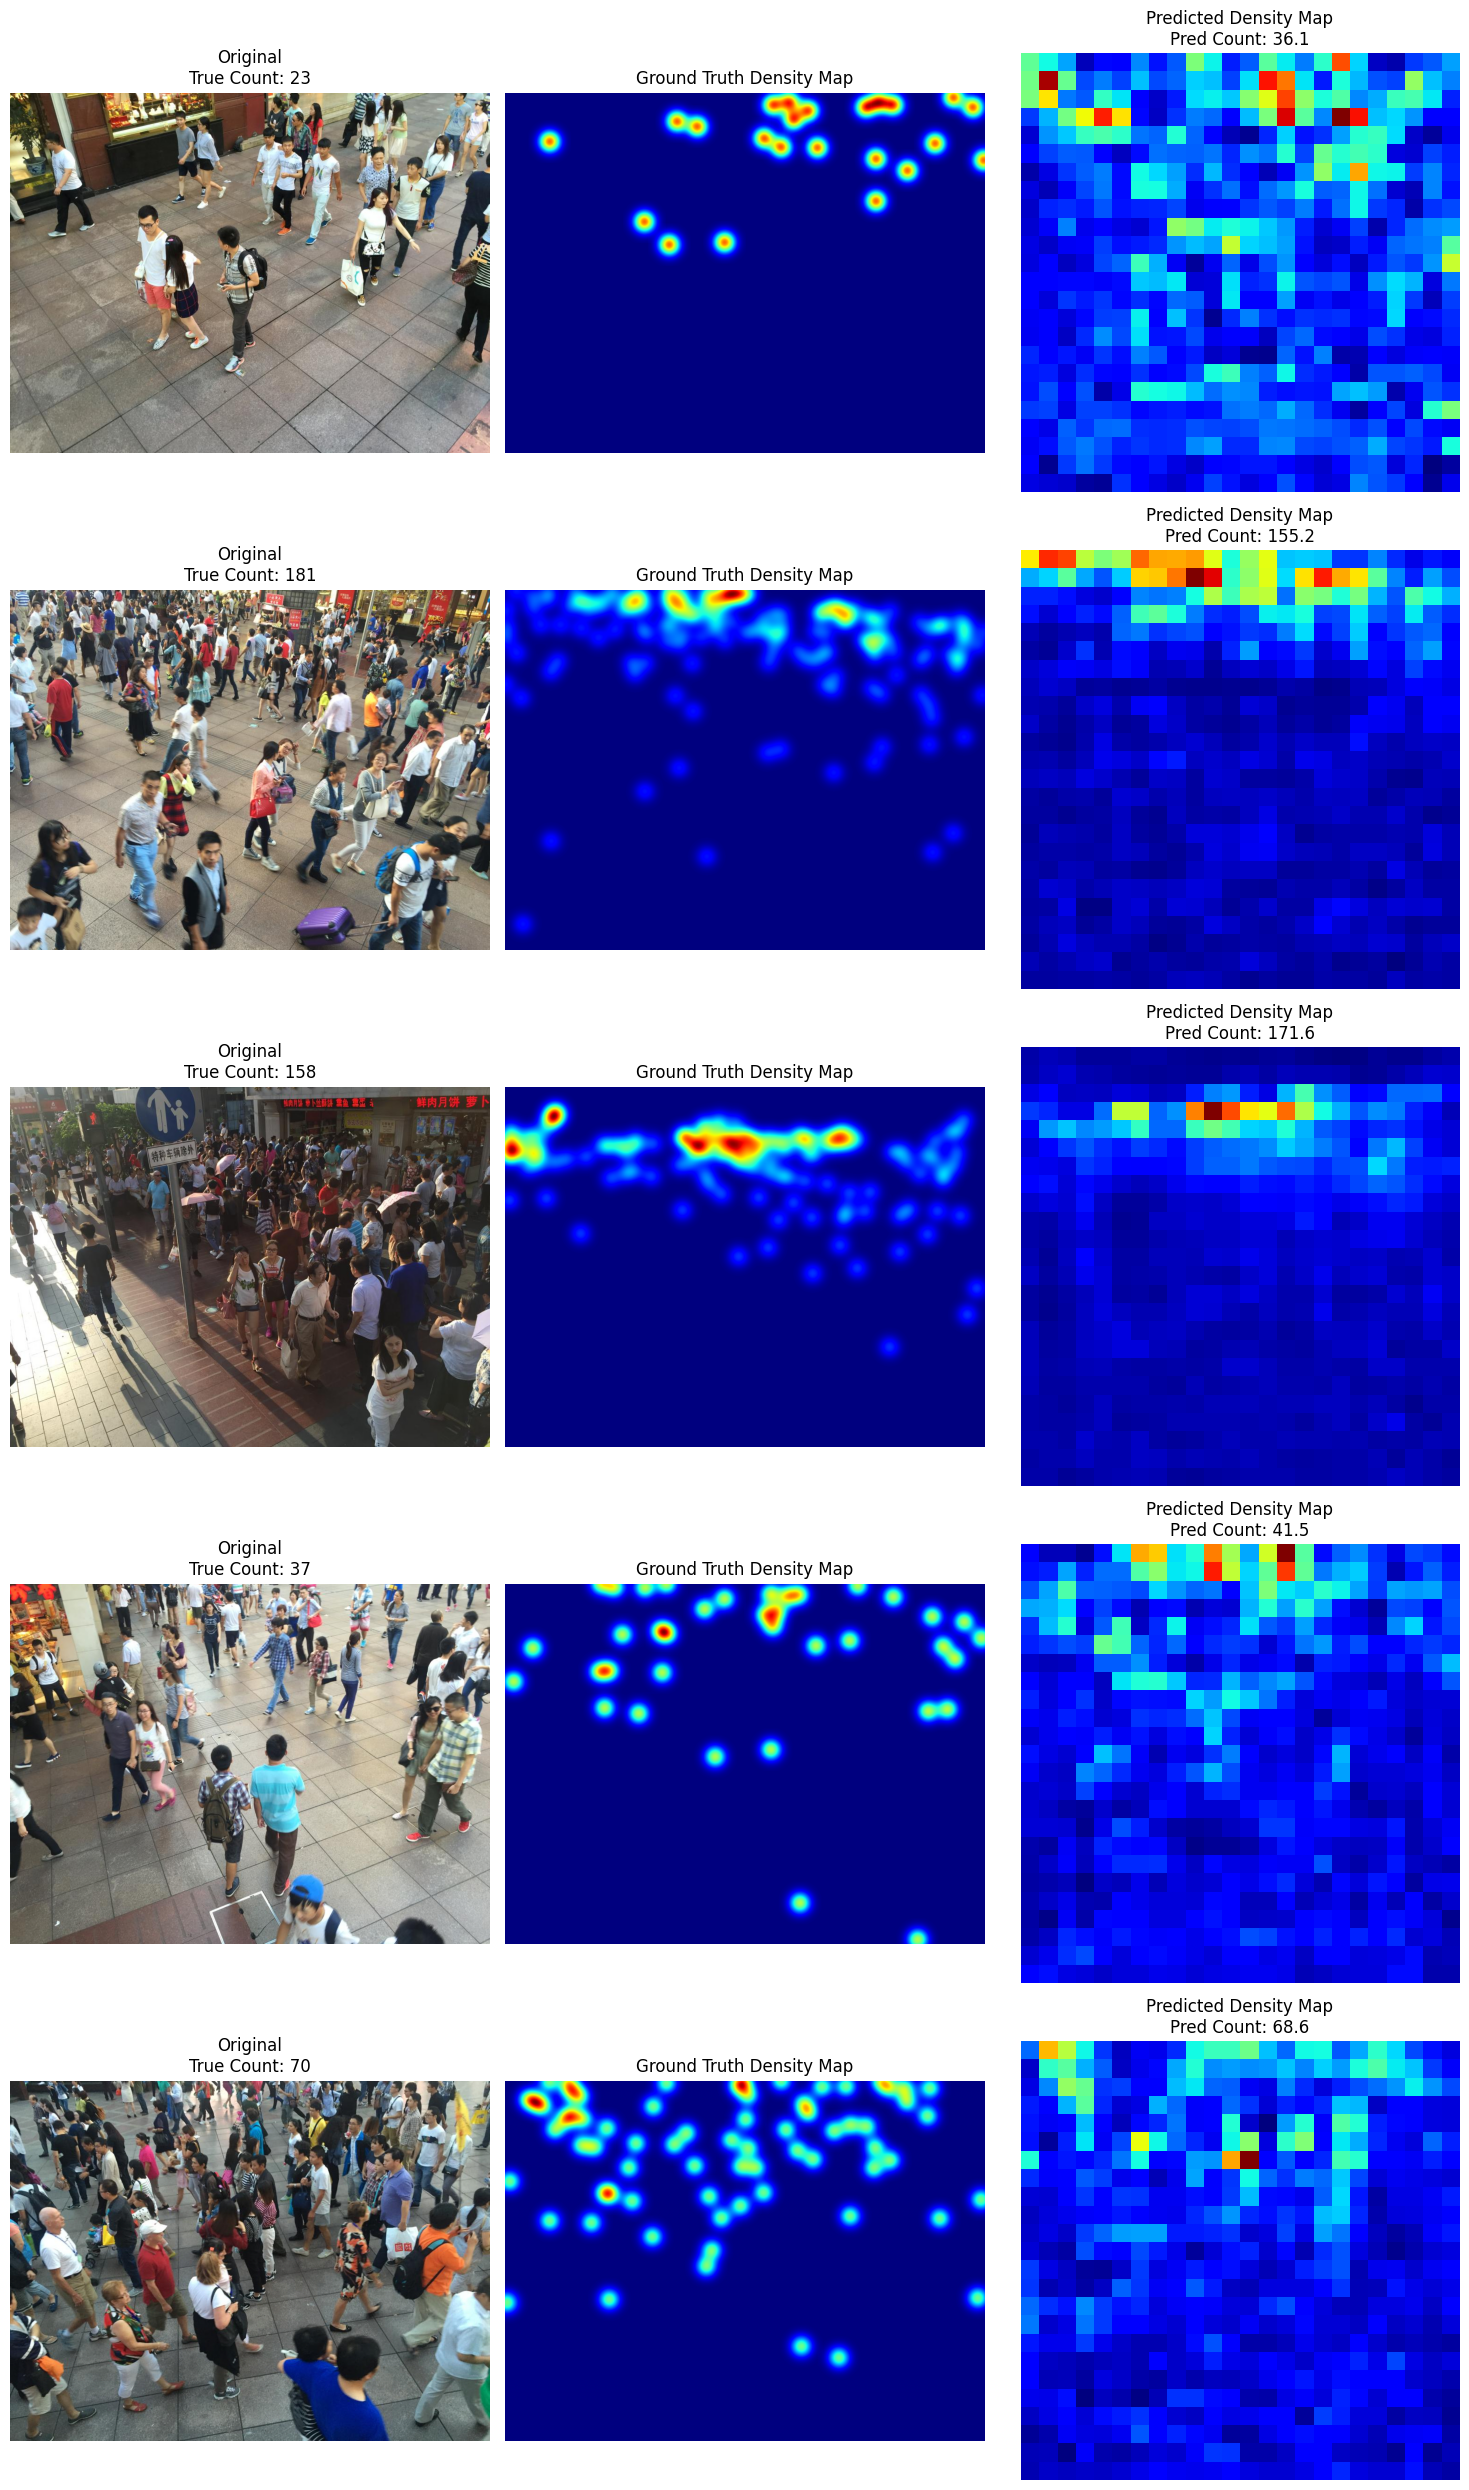

Pipeline completed successfully!


In [2]:
def visualize_results(model_path=None, num_samples=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DMCountPlusPlus().to(device)

    if model_path:
        model.load_state_dict(torch.load(model_path, map_location=device))

    test_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_dataset = DMCountDataset(TEST_IMAGE_DIR, TEST_GT_DIR,
                                 transform=test_transform, is_train=False)

    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(min(num_samples, len(test_dataset))):
        image_tensor, density_map, true_count = test_dataset[i]
        img_name = test_dataset.image_files[i]
        img_path = os.path.join(TEST_IMAGE_DIR, img_name)
        original_image = Image.open(img_path)
        with torch.no_grad():
            image_batch = image_tensor.unsqueeze(0).to(device)
            output = model(image_batch)
            predicted_count = output.sum().item()

        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f'Original\nTrue Count: {true_count}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(density_map.squeeze().numpy(), cmap='jet')
        axes[i, 1].set_title('Ground Truth Density Map')
        axes[i, 1].axis('off')

        pred_density = output.squeeze().cpu().numpy()
        axes[i, 2].imshow(pred_density, cmap='jet')
        axes[i, 2].set_title(f'Predicted Density Map\nPred Count: {predicted_count:.1f}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/crowd_counting_results.png', dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    print("Starting DM-count++ Crowd Counting Pipeline...")

    # Step 1: Preprocess dataset (optional - for faster loading)

    # Step 2: Train the model
    model = train_model()

    # Step 3: Evaluate the model
    print("\nEvaluating model...")
    predictions, ground_truths = evaluate_model('/content/drive/MyDrive/best_dmcount_model.pth')

    # Step 4: Visualize results
    print("\nGenerating visualizations...")
    visualize_results('/content/drive/MyDrive/best_dmcount_model.pth', num_samples=5)

    print("Pipeline completed successfully!")